In [1]:
from config import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# import all charging power predictions from directory
df_list = []
for file in os.listdir(result_directory + os.sep + "generatePredictions"):
    if file.endswith(".csv"):
        df_loaded = pd.read_csv(result_directory + os.sep + "generatePredictions" + os.sep + file, index_col = 0)
        # append one column to the dataframe
        df_list.append(df_loaded)

choose_column = "Power_original"

In [2]:
# get taz number of each charging station
taz_list = []
for file in os.listdir(result_directory + os.sep + "generatePredictions"):
    if file.endswith(".csv"):
        taz_list.append(file.split(".")[0])

In [3]:
def construct_numpy_array(df_list, choose_column):
    # construct numpy array
    array = np.zeros((len(df_list), len(df_list[0]))) # vector of shape (number of charging stations, number of time steps)
    timevector = df_list[0]["time"].to_numpy()
    for i in range(len(df_list)):
        array[i] = df_list[i][choose_column]
    return array, timevector

array, timevector = construct_numpy_array(df_list, "Power_original")

In [4]:
timevector[10:20]

array([ 660,  720,  780,  840,  900,  960, 1020, 1080, 1140, 1200],
      dtype=int64)

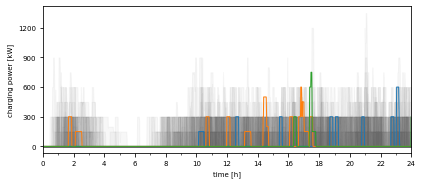

In [32]:
'''I only use this graphic in the paper'''
# plot all charging power predictions in one figure
%matplotlib inline
plt.figure()
pltSettings()
# set the color of the lines
for i in range(array.shape[0]):
    #plt.step(timevector/3600, array[i], color = 'dimgrey', alpha = 0.15, linewidth = 0.2)
    # fill area between lines
    plt.fill_between(timevector/3600, array[i], color= 'dimgrey', alpha = 0.05)
plot_index = [20,100, 58]
#color_list = plt.cm.Set1(np.linspace(0,1,len(plot_index)))
for i in range(len(plot_index)):
    plt.plot(timevector/3600, array[plot_index[i]], linewidth = 1)
plt.xlabel("time [h]")
plt.ylabel("charging power [kW]")
#plt.title("Charging power predictions")
ax = plt.gca()
ax.set_xlim([0,24])
ax.set_xticks(np.arange(0,25,2))
# set minor ticks inbetween
ax.set_xticks(np.arange(0,25,1), minor = True)
ax.set_yticks(np.arange(0, array.max(), 300))
fig = plt.gcf()
fig.set_size_inches(6.6, 2.7) #6.6, 2.7)

# save figure as pdf
fig.savefig(directory_figures + os.sep + "chargingPowerPredictions.pdf", bbox_inches='tight')

In [15]:
sum(array[10])

23122.5

In [13]:
array.shape

(159, 1440)

In [ ]:
# perform k-means clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

silhouette_scores = []
n_cluster_list = np.arange(2, 31, 1).astype(int)

X = array # X of shape (n_samples, n_features), n_samples are charging stations, n_features power prediction at time t
scaler = MinMaxScaler()
X_scaled = X #scaler.fit_transform(X)

for n_clusters in n_cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)


In [ ]:
max_index = np.argmax(silhouette_scores)
n_clusters = n_cluster_list[max_index]
print("The optimal number of clusters is: ", n_clusters)

In [ ]:
# plot silhouette scores
plt.figure()
pltSettings()
plt.plot(n_cluster_list, silhouette_scores, color = 'dimgrey', linewidth = 0.5)
plt.xlabel("number of clusters")
plt.ylabel("silhouette score")
plt.title("Silhouette scores")

### try with three hour energy demands

In [11]:
timestep_in_min_new = 180
timestep_new = timestep_in_min_new*60 # 15 minutes
timevector_new = np.arange(1, 24*3600, timestep_new)
array_new = np.zeros((array.shape[0], len(timevector_new)))
for i in range(array.shape[0]):# loop through charging station
    j0 = 0
    for j in range(len(timevector_new)):# loop through time steps
        array_new[i,j] = sum(array[i, j0:j0+timestep_in_min_new]*timestep/3.6e3) # to calculate energy, multiply with timestep/3.6e3 in kWh
        j0 = j0 + timestep_in_min_new

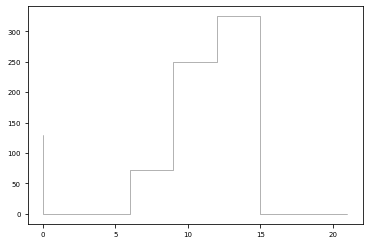

In [12]:
# plot for one charging station
%matplotlib inline
plt.figure()
pltSettings()
plt.step(timevector_new/3600, array_new[100], color = 'dimgrey', linewidth = 0.5)

In [10]:
# plot all charging power predictions in one figure
%matplotlib qt
plt.figure()
pltSettings()
# set the color of the lines
colors = plt.cm.jet(np.linspace(0,1,array.shape[0]))
for i in range(array_new.shape[0]):
    plt.plot(timevector_new/3600, array_new[i], color = 'dimgrey', alpha = 0.4, linewidth = 1)
plt.xlabel("time [h]")
plt.ylabel("charging power [kW]")
#plt.title("Charging power predictions")
ax = plt.gca()
ax.set_xlim([0,24])
ax.set_xticks(np.arange(0,25,2))
# set minor ticks inbetween
ax.set_xticks(np.arange(0,25,1), minor = True)
ax.set_yticks(np.arange(0, array_new.max(), 300))
fig = plt.gcf()
fig.set_size_inches(plotSizeX, 1.4* plotSizeY) #
fig.set_size_inches(6.6, 2.7)

# save figure as pdf
fig.savefig(directory_figures + os.sep + "chargingPowerPredictions.pdf", bbox_inches='tight')

In [ ]:
silhouette_scores = []
n_cluster_list = np.arange(2, 20, 1).astype(int)

X = array_new # X of shape (n_samples, n_features), n_samples are charging stations, n_features power prediction at time t
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

for n_clusters in n_cluster_list:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
max_index = np.argmax(silhouette_scores)
n_clusters = n_cluster_list[max_index]
print("The optimal number of clusters is: ", n_clusters)

In [ ]:
# get the second highest silhouette score
silhouette_scores_sorted = np.sort(silhouette_scores)
silhouette_scores_sorted[-2]
# get the number of clusters corresponding to the second highest silhouette score
n2 = n_cluster_list[np.where(silhouette_scores == silhouette_scores_sorted[-2])]
print("The second optimal number of clusters is: " + str(n2))

In [ ]:
# plot silhouette scores
%matplotlib inline
plt.figure
pltSettings()
plt.plot(n_cluster_list, silhouette_scores, color = 'dimgrey', linewidth = 0.5)
plt.xlabel("number of clusters")
plt.ylabel("silhouette score")
plt.title("Silhouette scores")

In [ ]:
# print stats of clusters
n_clusters = 5

clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X_scaled)
cluster_found = pd.Series(cluster_labels, name = "cluster")

for i in range(n_clusters):
    cluster = cluster_found[cluster_found == i]
    print("Cluster ", i, " has ", len(cluster), " charging stations.")

### plot clusters

In [ ]:
# let see how the clusters look
%matplotlib qt
clusterer = KMeans(n_clusters=n_clusters, random_state=10)
cluster_labels = clusterer.fit_predict(X_scaled)
cluster_found = pd.Series(cluster_labels, name = "cluster")

# plot all charging power predictions in one figure
fig, ax = plt.subplots(1,1, figsize = (6.6, 3.6))
pltSettings()
# choose colormap set1
color_list = plt.cm.hsv(np.linspace(0,1,n_clusters))
df_array = pd.DataFrame(array)
df_array = df_array.set_index(cluster_found, append = True)

# sort by number of occurences of cluster
value_count = cluster_found.value_counts(ascending=True)
plot_order = value_count.index.tolist()

for i in plot_order:
    cluster = cluster_found[cluster_found == i]
    for j in cluster.index:
        ax.plot(timevector/3600, array[j], color = color_list[i], alpha = 0.30, linewidth = 1)
    cluster = cluster_found[cluster_found == i]
    ax.plot(timevector/3600, array[cluster.index].mean(axis = 0), color = color_list[i], linewidth = 0.8)
    # make color a bit darker
    color_list[i] = [x*0.8 for x in color_list[i]]
    #ax.plot(timevector/3600, array[j], color = color_list[i], linewidth = 0.5, alpha = 1) #ls = 'dotted')
ax.set_xlabel("time [h]")
ax.set_ylabel("charging power [kW]")
ax.set_xlim([0,24])
ax.set_xticks(np.arange(0,25,4))
# set minor ticks inbetween
ax.set_xticks(np.arange(0,25,1), minor = True)
ax.set_yticks(np.arange(0, array.max(), 300))
fig.set_size_inches(6.6, 2.8) #6.6, 2.7)
#fig.set_size_inches(plotSizeX, 1.7* plotSizeY) #6.6, 2.7)
plt.show()
fig.savefig(directory_figures + os.sep + "chargingPowerPredictions_clustered.pdf", bbox_inches='tight')
# show plot on other screen

In [ ]:
# print stats of clusters
for i in range(n_clusters):
    cluster = cluster_found[cluster_found == i]
    print("Cluster ", i, " has ", len(cluster), " charging stations.")

In [ ]:
151/159

In [ ]:
# plot one example of each cluster
fig, ax = plt.subplots(1,1, figsize = (6.6, 3.6))
pltSettings()
# choose colormap set1
color_list = plt.cm.hsv(np.linspace(0,1,n_clusters))

df_array = pd.DataFrame(array)
df_array = df_array.set_index(cluster_found, append = True)

# sort by number of occurences of cluster
value_count = cluster_found.value_counts(ascending=True)
plot_order = value_count.index.tolist()

# plot only for cluster type 3 some trajectories
cluster = cluster_found[cluster_found == 3]
for j in np.random.randint(0, len(cluster), 3):
    ax.plot(timevector/3600, array[cluster.index[j]], linewidth = 1)
ax.set_xlabel("time [h]")
ax.set_ylabel("charging power [kW]")
ax.set_xlim([0,24])
ax.set_xticks(np.arange(0,25,4))
# set minor ticks inbetween
ax.set_xticks(np.arange(0,25,1), minor = True)
ax.set_yticks(np.arange(0, array.max(), 300))
fig.set_size_inches(6.6, 2.8) #6.6, 2.7)
#fig.set_size_inches(plotSizeX, 1.7* plotSizeY) #6.6, 2.7)
plt.show()
fig.savefig(directory_figures + os.sep + "chargingPowerPredictions_examples.pdf", bbox_inches='tight')

In [ ]:
# make plot from every charging station and save as png

for i in range(array.shape[0]):
    fig, ax = plt.subplots(1,1, figsize = (6.6, 3.6))
    pltSettings()
    # set font size to 18
    plt.rcParams.update({'font.size': 18})
    ax.plot(timevector/3600, array[i], linewidth = 1)
    ax.set_xlabel("time [h]")
    ax.set_ylabel("charging power [kW]")
    ax.set_xlim([0,24])
    ax.set_xticks(np.arange(0,25,4))
    # set minor ticks inbetween
    ax.set_xticks(np.arange(0,25,1), minor = True)
    ax.set_yticks(np.arange(0, array.max(), 300))
    fig.set_size_inches(4*6.6, 4*2.8) #6.6, 2.7)
    #fig.set_size_inches(plotSizeX, 1.7* plotSizeY) #6.6, 2.7)
    fig.savefig(directory_figures + os.sep + "all_predictions" + os.sep + "chargingPowerPredictions_" + taz_list[i] + ".jpg", bbox_inches='tight')
    plt.close(fig)